# **Stratification of (MEP3) grades using *machine learning with clustering* rather than weighted averages**


## Background

Mechanical engineering practice 3 (MEP-III) is a course in which "students apply the engineering design process by combining engineering science with simulation tools to guide design decisions." In teams of ~4 students, created using CATME, they work on modeling a horizontal mover (such as a moving walkway, a tramcar, automated bookshelfs for a library...).  

In this course summative assessment is used through a weighted average of student scores in the categories: "homework", "exams", "team work".  "Homeworks" are individual student efforts, "team work" allows for leadership and group dynamics aspects to assert themselves, "exams" are individual effort with a more severe time constraint than "homework".   Typically, students have between 5-7 days to work on homeworks while exams are of 110 minute duration.  Teamwork in itself is a CATME weighted average of team deliverables.  Each member of a team, receives a portion of the total score on team deliverables.  This portion is dictated through peer-review scores that team members complete for each other, via CATME.

## The problem

The weighted average technique is not sensitive to the differing nature (of perhaps meta-skills required?) of student performance in the three categories.  This leads to students possessing different strengths being "***painted with the same brush***".  From anecdotal evidence, students have succeeded in circumventing CATME's capabilities and resorting to manipulating team members in such fashion that is not captured in CATME.

In the approach that follows, student summative assessment scores are stratified into clusters or groups using the K-Means clustering approach.  In contrast to the weighted average technique, this clustering approach stratifies students with similar score attributes.  This stratification is absent in the weighted average technique.  

# Preamble

In [0]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#plt.style.use('fivethirtyeight') #Plot style preferred by author.

import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

from tabulate import tabulate #pretty display of tables

import plotly.express as px
from plotly.subplots import make_subplots


#https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html


# Importing data and preliminary visualization

In [3]:
#@title
#url = 'https://raw.githubusercontent.com/dnaneet/SVD_PCA/master/grading/mep3_f17_lg.csv'
url2 ='https://raw.githubusercontent.com/dnaneet/SVD_PCA/master/grading/mep3_f17_catme.csv'
 
df1 = pd.read_csv(url2, names=["homework", "teamwork", "exams", 
                               "total", "letter grade", "rank",
                               "CATME (early)", "CATME (final)", "CATME (avg)"])

performance = df1.values
scores = performance[:,0:3]
total = performance[:,3]
print(df1.dtypes)
#weather["Temp"] = weather.Temp.convert_objects(convert_numeric=True)

df1["homework"] = df1["homework"]*100/200;
df1["teamwork"] = df1["teamwork"]*100/400
df1["exams"] = df1["exams"]*100/400
df1["total"] = df1["total"]

len(df1)
#sns.pairplot(df1.iloc[:,0:3], 
#             markers="+",
#             diag_kind='kde',
#             kind='reg')
#plt.ylim(0, 20)
#plt.xlim(0, 100)

homework           int64
teamwork           int64
exams              int64
total            float64
letter grade      object
rank               int64
CATME (early)      int64
CATME (final)      int64
CATME (avg)      float64
dtype: object


188

### Histogram of scores in each category

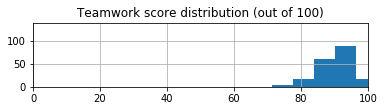

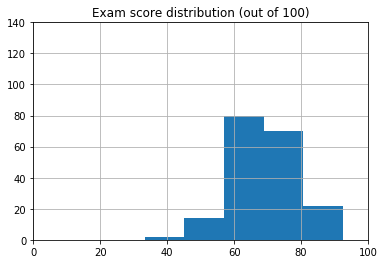

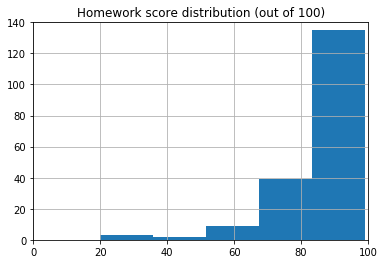

In [0]:
#sns.jointplot(data=df1,
#                   x='exams', 
#                   y='teamwork', 
#                   kind='kde',
#                   space=0, size=6, ratio=4)
#@title
fig=plt.figure()
ax1 = fig.add_subplot(311)
df1["teamwork"].hist(bins=5)
plt.xlim((0, 100))
plt.ylim((0,140))
plt.title("Teamwork score distribution (out of 100)")
plt.show()

ax2 = fig.add_subplot(312)
df1["exams"].hist(bins=5)
plt.xlim((0, 100))
plt.ylim((0,140))
plt.title("Exam score distribution (out of 100)")
plt.show()

ax3 = fig.add_subplot(313)
df1["homework"].hist(bins=5)
plt.xlim((0, 100))
plt.ylim((0,140))
plt.title("Homework score distribution (out of 100)")
plt.show()


### 3D scatter plot of scores in three categories

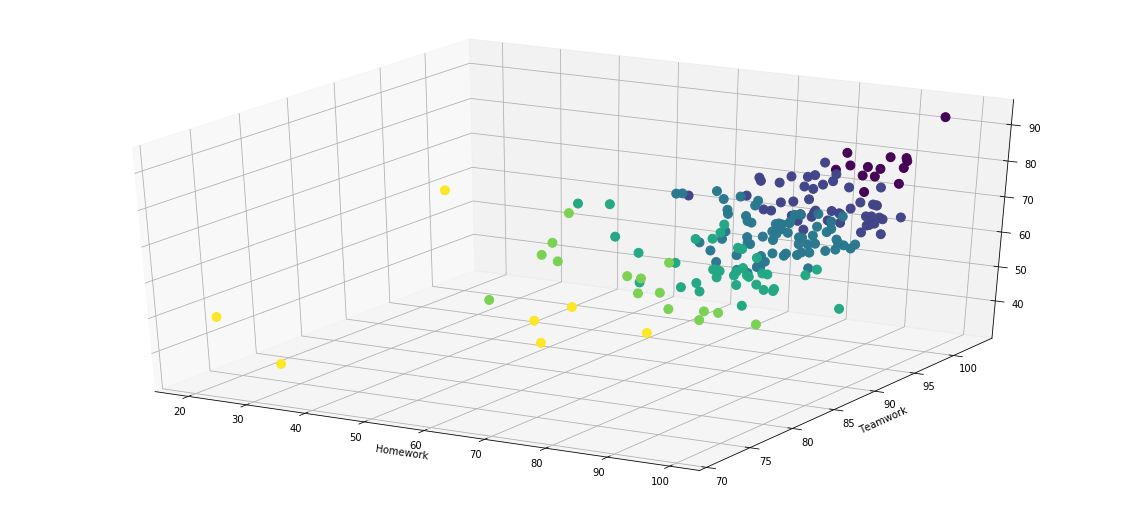

In [0]:
#@title
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(df1['homework'], df1['teamwork'], df1['exams'], s=80, c=df1['rank'], alpha=0.99)
#ax.view_init(90, 90)
plt.xlabel('Homework')
plt.ylabel('Teamwork')
#plt.zlabel('Exams')
plt.show()

In [0]:
print(tabulate(df1.sample(n=10, random_state=1),headers=["Homework", "Teamwork", "Exams", 
                                                         "Cumulative", "Letter grade", "'Rank'", 
                                                         "CATME1", "CATME2", "CATME avg"]))

       Homework    Teamwork    Exams    Cumulative  Letter grade      'Rank'    CATME1    CATME2    CATME avg
---  ----------  ----------  -------  ------------  --------------  --------  --------  --------  -----------
 31        91         85.75    81.25          85    AB                     2        84        78         81
 66        92         87.25    76             83.7  B                      3        72        49         60.5
112        93         84       68.5           79.6  B                      3        82        83         82.5
120        84         94.75    70             82.7  B                      3        68        75         71.5
 81        89         95.5     68.5           83.4  B                      3        80        78         79
152        92.5       82.5     58.25          74.8  BC                     4        72        86         79
 35        93.5       92       83.75          89    AB                     2        64        74         69
102        86.5   

### Dynamic visualization: "Mixing" of grades between BC -- F

In [0]:
#@title
import plotly.express as px
from plotly.subplots import make_subplots


fig = px.scatter_3d(df1.iloc[:,0:9], x='homework', y='teamwork', z='exams', 
                    color='letter grade') #letter grade
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10),
                  height=800, width=800, title_text="letter grades")
fig.show()

# Data processing: scaling, principal component analysis, clustering

## Scaling

In [0]:
#@title
scaler = StandardScaler()
scores_scaled = scaler.fit_transform(df1)
#print(scores)
type(scores_scaled)
#scores_scaled


numpy.ndarray

## Principal component analysis: Let's compare Apples to Apples and not Apples to Cantaloupes

[0.68482417 0.24167141]


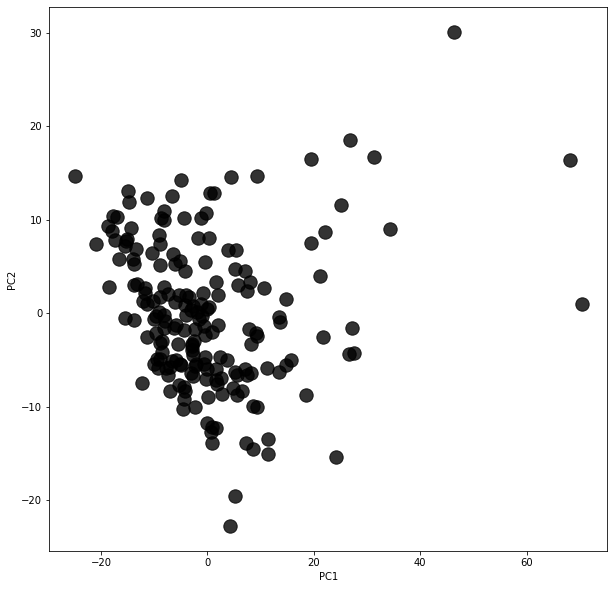

,pc1,pc2
0,-20.910156,7.429680
1,-16.685801,5.819245
2,-17.831342,10.426613
3,-15.243761,7.687184
4,-24.975616,14.652161


In [4]:
#@title
pca = sklearnPCA(n_components=2) #2-dimensional PCA
pca_scores = pca.fit_transform(df1.iloc[:,0:3])
print(pca.explained_variance_ratio_)  
transformed = pd.DataFrame(pca_scores)
#print(transformed.head(5))
pca12 = np.array(transformed)

plt.figure(figsize=(10,10))
plt.scatter(pca12[:,0], pca12[:,1],  s=180, c='black', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


pca_df = pd.DataFrame({'pc1': pca12[:, 0], 'pc2': pca12[:, 1]})
pca_df.head(5)

#fig=px.scatter(pca_df, x="pc1", y="pc2")
#fig.show()

## Visualization of the principal components

In [0]:
#@title
plt.figure(figsize=(8,1))
plt.scatter(pca12[:,0] ,np.zeros(len(total)), s=30)
plt.show()
plt.figure(figsize=(8,1))
plt.scatter(total, np.zeros(len(total)), s=30)

## Clustering

### K-Means clustering

[[-10.59428873   7.4011446 ]
 [ 23.32485729   6.85829476]
 [  7.28518547  -7.28087278]
 [ -4.14010955  -2.51321534]
 [ 61.67009934  15.80786049]]


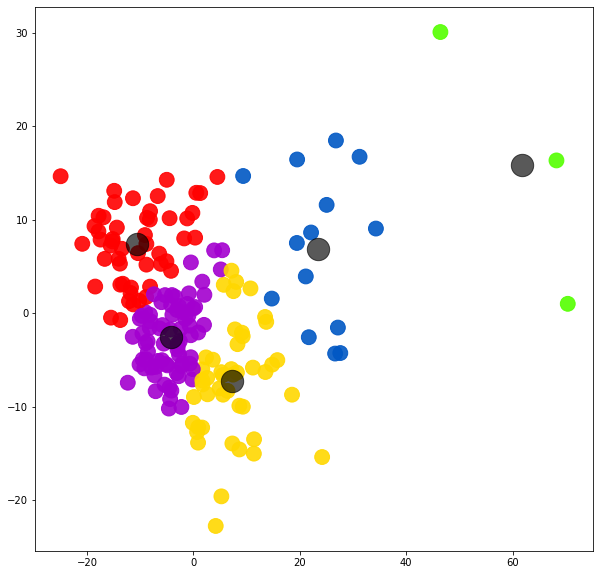

In [9]:
#@title
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5,random_state=0)
kmeans.fit(pca12)
labels_kmean = kmeans.predict(pca12)

plt.figure(figsize=(10,10))
plt.scatter(pca12[:, 0], pca12[:, 1], c=labels_kmean, s=220, cmap='prism', alpha=0.9)

centers = kmeans.cluster_centers_
print(centers)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.65);
plt.show()



### Spectral clustering (under development)

In [0]:
#@title
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=6, affinity='nearest_neighbors',
                           assign_labels='kmeans',random_state=0)
labels_spectral = spectral.fit_predict(pca12)

plt.figure(figsize=(3,3))
plt.scatter(pca12[:, 0], pca12[:, 1], c=labels_spectral, s=60, cmap='viridis', alpha=0.85)


# Visualization of student scores in terms of letter grade vs clusters

In [0]:
#@title
df1["kmeans cluster"] = labels_kmean
df2 = df1.sort_values('kmeans cluster')
#df2.sample(n=10, random_state=1)

In [0]:
#@title
#@Misc plots
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2['homework'], df2['teamwork'], df2['exams'], s=50, c=df2['kmeans cluster'])
#ax.view_init(90, 90)
ax.set_xlabel('Homework')
ax.set_ylabel('Teamwork')
ax.set_zlabel('Exams')
plt.show()


sizes = 20*df2['total']

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2['homework'], df2['teamwork'], df2['exams'], s=50, c=df2['rank'])
#ax.view_init(90, 90)
ax.set_xlabel('Homework')
ax.set_ylabel('Teamwork')
ax.set_zlabel('Exams')
plt.show()

In [0]:
#@title
#df2.head(5)
fig = px.scatter_3d(df2.iloc[:,0:7], x='homework', y='teamwork', z='exams', 
                    color='letter grade')
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()

In [10]:
#@title
fig = px.scatter_3d(df2.iloc[:,0:10], x='homework', y='teamwork', z='exams', 
                    color='kmeans cluster')
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()

# Inclusion of CATME evaluation scores (in development)

In [13]:
#@title
fig = px.scatter_3d(df2.iloc[:,0:11], x='homework', y='teamwork', z='exams', 
                    color='CATME (avg)')
fig.update_layout(scene = dict(
        xaxis = dict(nticks=4, range=[0,110],),
                     yaxis = dict(nticks=4, range=[0,110],),
                     zaxis = dict(nticks=4, range=[0,110],),),
                     margin=dict(r=20, l=10, b=10, t=10))
fig.show()